In [1]:
import gzip
import sklearn
from sklearn import linear_model
from collections import defaultdict
import random
import math
import numpy as np
from sklearn.metrics import jaccard_score as jaccard

# Tasks (Play prediction)
### Play prediction (both classes) 
#### Predict given a (user,game) pair from ‘pairs Played.txt’ whether the user would play the game (0 or 1). Accuracy will be measured in terms of the categorization accuracy (fraction of correct predictions). The test set has been constructed such that exactly 50% of the pairs correspond to played games and the other 50% do not.

In [2]:
def parse(f):
    for l in gzip.open(f):
        yield eval(l)

In [3]:
train_json = list(parse("data/train.json.gz"))

In [4]:
train_json[0]

{'hours': 0.3,
 'gameID': 'b96045472',
 'hours_transformed': 0.37851162325372983,
 'early_access': False,
 'date': '2015-04-08',
 'text': '+1',
 'userID': 'u01561183'}

In [5]:
data = [[d['userID'],d['gameID'],1] for d in train_json]

split = 165000
train = train_json[:split]
ug_train = [[d['userID'],d['gameID'],1] for d in train]
validation = train_json[split:]
ug_valid = [[d['userID'],d['gameID'],1] for d in validation]

#### Task 1

In [6]:
def readJSON(path):
  for l in gzip.open(path, 'rt'):
    d = eval(l)
    u = d['userID']
    try:
      g = d['gameID']
    except Exception as e:
      g = None
    yield u,g,d

In [ ]:
# ### Time-played baseline: compute averages for each user, or return the global average if we've never seen the user before

# allHours = []
# userHours = defaultdict(list)

# for user,game,d in readJSON("data/train.json.gz"):
#   h = d['hours_transformed']
#   allHours.append(h)
#   userHours[user].append(h)

# globalAverage = sum(allHours) / len(allHours)
# userAverage = {}
# for u in userHours:
#   userAverage[u] = sum(userHours[u]) / len(userHours[u])

In [ ]:
# predictions = open("predictions_Hours.txt", 'w')
# for l in open("data/pairs_Hours.txt"):
#   if l.startswith("userID"):
#     #header
#     predictions.write(l)
#     continue
#   u,g = l.strip().split('-')
#   if u in userAverage:
#     predictions.write(u + '-' + g + ',' + str(userAverage[u]) + '\n')
#   else:
#     predictions.write(u + '-' + g + ',' + str(globalAverage) + '\n')

# predictions.close()

In [ ]:
### Would-play baseline: just rank which games are popular and which are not, and return '1' if a game is among the top-ranked

# gameCount = defaultdict(int)
# totalPlayed = 0

# for user,game,_ in readJSON("data/train.json.gz"):
#   gameCount[game] += 1
#   totalPlayed += 1

# mostPopular = [(gameCount[x], x) for x in gameCount]
# mostPopular.sort()
# mostPopular.reverse()

# return1 = set()
# count = 0
# for ic, i in mostPopular:
#   count += ic
#   return1.add(i)
#   if count > totalPlayed/2: break

In [ ]:
# predictions = open("predictions_Played.txt", 'w')
# for l in open("data/pairs_Played.txt"):
#   if l.startswith("userID"):
#     #header
#     predictions.write(l)
#     continue
#   u,g = l.strip().split('-')
#   if g in return1:
#     predictions.write(u + '-' + g + ",1\n")
#   else:
#     predictions.write(u + '-' + g + ",0\n")

# predictions.close()

In [ ]:
# ### Category prediction baseline: Just consider some of the most common words from each category

# catDict = {
#   "Action": 0,
#   "Strategy": 1,
#   "RPG": 2,
#   "Adventure": 3,
#   "Sport": 4
# }

# predictions = open("predictions_Category.txt", 'w')
# predictions.write("userID-reviewID,prediction\n")
# for u,_,d in readJSON("data/test_Category.json.gz"):
#   cat = catDict['Action'] # If there's no evidence, just choose the most common category in the dataset
#   words = d['text'].lower()
#   if 'strategy' in words:
#     cat = catDict['Strategy']
#   if 'rpg' in words:
#     cat = catDict['RPG']
#   if 'adventure' in words:
#     cat = catDict['Adventure']
#   if 'sport' in words:
#     cat = catDict['Sport']
#   predictions.write(u + '-' + d['reviewID'] + "," + str(cat) + "\n")

# predictions.close()

#### Task 1

In [7]:
#gets users per game and games per user from entire dataset
usersPerGame = defaultdict(set)
gamesPerUser = defaultdict(set)
uniqueGames = set()

for d in data:
    u, g = d[0], d[1]
    usersPerGame[g].add(u)
    gamesPerUser[u].add(g)
    uniqueGames.add(g)

In [8]:
users_valid = [d[0] for d in ug_valid]

In [9]:
ug_valid_neg= []
for u in users_valid:
    gamesNotPlayed = uniqueGames - gamesPerUser[u]
    randomGame = random.choice(list(gamesNotPlayed))
    ug_valid_neg.append([u, randomGame,0])
    

In [10]:
ug_valid_neg[:10]

[['u49969792', 'b08286994', 0],
 ['u33147591', 'b41038309', 0],
 ['u00954406', 'b81039440', 0],
 ['u40416473', 'b73515692', 0],
 ['u08125051', 'b73825833', 0],
 ['u16794935', 'b65708637', 0],
 ['u42345370', 'b86627453', 0],
 ['u40134397', 'b99600313', 0],
 ['u38053603', 'b71138223', 0],
 ['u25257262', 'b22856743', 0]]

In [11]:
ug_valid[:10]

[['u49969792', 'b25961467', 1],
 ['u33147591', 'b73229067', 1],
 ['u00954406', 'b37068085', 1],
 ['u40416473', 'b85572219', 1],
 ['u08125051', 'b88846011', 1],
 ['u16794935', 'b19939295', 1],
 ['u42345370', 'b31288876', 1],
 ['u40134397', 'b22332890', 1],
 ['u38053603', 'b44539786', 1],
 ['u25257262', 'b64105731', 1]]

In [12]:
ug_valid_build = ug_valid + ug_valid_neg

In [13]:
ug_valid_build[9995:10005]

[['u90835702', 'b62891570', 1],
 ['u40505592', 'b75563467', 1],
 ['u67709233', 'b14676161', 1],
 ['u79727950', 'b36105300', 1],
 ['u25903175', 'b50879604', 1],
 ['u49969792', 'b08286994', 0],
 ['u33147591', 'b41038309', 0],
 ['u00954406', 'b81039440', 0],
 ['u40416473', 'b73515692', 0],
 ['u08125051', 'b73825833', 0]]

In [14]:
len(ug_valid_build)

20000

In [15]:
Xvalid = [[d[0],d[1]] for d in ug_valid_build]
yvalid = [d[2] for d in ug_valid_build]

Xtrain = [[d[0], d[1]] for d in ug_train]
ytrain = [d[2] for d in ug_train]

In [16]:


### Would-play baseline: just rank which games are popular and which are not, and return '1' if a game is among the top-ranked
##task 1 baseline
def baselinePreds(Xvalid, threshold):
    gameCount = defaultdict(int)
    totalPlayed = 0

    for user,game,_ in readJSON("data/train.json.gz"):
      gameCount[game] += 1
      totalPlayed += 1
 
        

    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
      count += ic
      return1.add(i)
      if count > totalPlayed/threshold: break


    #task 1 predictions
    predictions = []
    for user, game in Xvalid:
        if game in return1:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions

In [17]:
def computeAccuracy(preds, true):  
    correct = np.array(preds) == np.array(true)
    return sum(correct) / len(correct)


In [18]:
preds = baselinePreds(Xvalid,2)

In [19]:
#accuracy of baseline model on validation set
th2_acc = computeAccuracy(preds, yvalid)
th2_acc

0.68205

#### Task 2

#### my choice for thresholds was to keep it low, and see if being more selective in terms of popularity percentile would yield a better model, as you can see it performed slightly better in terms of accuracy

In [20]:
# my choice for thresholds was to keep it low, and see if being more selective 
#in terms of popularity percentile would yield a better model

def bestThreshold():
    best_th = 2
    best_acc = th2_acc
    for i in np.arange(1,2.05,.05):
        acc = computeAccuracy(baselinePreds(Xvalid,i), yvalid)
        if acc > best_acc:
            best_th = i
            best_acc = acc
    return best_th, best_acc

bestThreshold()

(1.5000000000000004, 0.70355)

#### Task 3

In [21]:
import matplotlib.pyplot as plt

In [22]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

In [23]:
#all users for a specific game in training data
#all games for a specific user in training data
usersPerGame = defaultdict(set)
gamesPerUser = defaultdict(set)
for u,g in Xtrain:
    usersPerGame[g].add(u)
    gamesPerUser[u].add(g)
    

In [24]:
def similarityScores(user, game):
    #consider g' in training set that a user has played
    g_primes = gamesPerUser[user]
    similarities = []
    
    if len(g_primes) == 0:
        similarities.append(0)
        return similarities
    
    for g_prime in g_primes:
        if g_prime == g:
            continue
        #users in training data who have played g
        ugTrain = usersPerGame[game]
        #users who have played g'
        ugPrime = usersPerGame[g_prime]
        if len(ugPrime) == 0:
            similarities.append(0)
        else:
            similarities.append(Jaccard(ugTrain,ugPrime))
        
    return similarities

In [25]:
max_scores = []
for user, game in Xvalid:
    max_scores.append(np.max(similarityScores(user, game)))

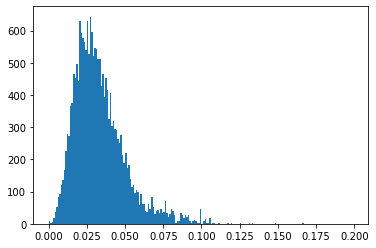

In [26]:
plt.hist(max_scores, bins = np.arange(0,.2,.001))
plt.show()

(array([2.502e+03, 9.094e+03, 5.712e+03, 1.680e+03, 6.940e+02, 2.630e+02,
        4.800e+01, 4.000e+00, 2.000e+00, 1.000e+00]),
 array([0.        , 0.01666667, 0.03333333, 0.05      , 0.06666667,
        0.08333333, 0.1       , 0.11666667, 0.13333333, 0.15      ,
        0.16666667]),
 <a list of 10 Patch objects>)

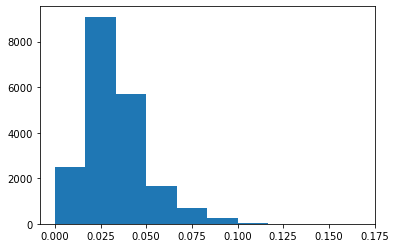

In [27]:
plt.hist(max_scores)

In [28]:
def jaccard_preds(max_scores,th):
    predictions = []
    for sim in max_scores:
        if sim > th:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [29]:
def bestThreshold():
    best_th = 0
    best_acc = 0
    for th in np.arange(0,.1,.001):
        preds = jaccard_preds(max_scores,th)
        acc = computeAccuracy(preds, yvalid)
        if acc > best_acc:
            best_th = th
            best_acc = acc
            
    return (best_th, best_acc)
bestThreshold()

(0.03, 0.67515)

#### Task 4

#### Incorporating both a Jaccard-based threshold and a popularity threshold seemed to perform better than just a Jaccard-based threshold alone, but not quite as well as a popularity based threshold alone.

In [30]:
def baselinePreds4(ug_valid_build, j_th,pop_th):
    gameCount = defaultdict(int)
    totalPlayed = 0

    for user,game,_ in readJSON("data/train.json.gz"):
        gameCount[game] += 1
        totalPlayed += 1

    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalPlayed/pop_th: break


#     #task 1 predictions
#     predictions = []
#     for user, game, _ in ug_valid_build:
#         if game in return1:
#             predictions.append(1)
#         else:
#             predictions.append(0)


#     predictions_or = []
#     for user, game, _ in ug_valid_build:
#         mostSim = similarityScores(user, game)
#         if (game in return1) or (max(mostSim) >= j_th):
#             predictions_or.append(1)
#         else:
#             predictions_or.append(0)
            
    predictions_and = []
    for user, game, _ in ug_valid_build:
        mostSim = similarityScores(user, game)
        if (game in return1) and (max(mostSim) >= j_th):
            predictions_and.append(1)
        else:
            predictions_and.append(0)
    return predictions_and

In [32]:
preds_and = baselinePreds4(ug_valid_build,.03,1.5)
and_acc = computeAccuracy(preds_and, yvalid)
print(and_acc)

0.69435


#### redesign model
##### when passing the best threshold from q2 and q3 into the function above i mistyped one of the thresholds and managed to get an unexpected accuracy, so I ran a script to see if combining different jaccard-based thresholds and popularity thresholds would give better accuracy, or if the optimal thresholds from q2 and q3 were still the best, unfortunately the run time was a couple of hours because I was testing a large range of every possible combination for jaccard/popularity thresholds, i also redid some of the conditional statements for a more lenient predictor
##### the pseudo code for finding a better threshold combo is having two for loops, one outer and one nested, one loops through a range in jaccard thresholds and the other loops through some popularity threshold, then i run baselinePreds4 passing in those thresholds, compute accuracies and print out the accuracies with the thresholds to see which combo gives the best result in the redesigned baseline predictor

In [33]:
def baselinePreds4(ug_valid_build, j_th,pop_th):
    gameCount = defaultdict(int)
    totalPlayed = 0

    for user,game,_ in readJSON("data/train.json.gz"):
        gameCount[game] += 1
        totalPlayed += 1

    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalPlayed/pop_th: break


#     #task 1 predictions
#     predictions = []
#     for user, game, _ in ug_valid_build:
#         if game in return1:
#             predictions.append(1)
#         else:
#             predictions.append(0)


#     predictions_or = []
#     for user, game, _ in ug_valid_build:
#         mostSim = similarityScores(user, game)
#         if (game in return1) or (max(mostSim) >= j_th):
#             predictions_or.append(1)
#         else:
#             predictions_or.append(0)
            
    predictions_and = []
    for user, game, _ in ug_valid_build:
        mostSim = similarityScores(user, game)
        if (game in return1):
            predictions_and.append(1)
        else:
            if (game not in return1) and (max(mostSim) > j_th):
                predictions_and.append(1)
            else:
                predictions_and.append(0)
    return predictions_and


        


In [34]:
preds_and = baselinePreds4(ug_valid_build,.048,1.51)
and_acc = computeAccuracy(preds_and, yvalid)
print(and_acc)

0.70595


#### Task 5

#### Kaggle Username: anthonylimon

In [36]:
j_th = .048
pop_th = 1.51

gameCount = defaultdict(int)
totalPlayed = 0

for user,game,_ in readJSON("data/train.json.gz"):
    gameCount[game] += 1
    totalPlayed += 1

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalPlayed/pop_th: break
            
# predictions_and = []
# for user, game, _ in ug_valid_build:
#     mostSim = similarityScores(user, game)
#     if (game in return1):
#         predictions_and.append(1)
#     else:
#         if (game not in return1) and (max(mostSim) >= j_th):
#             predictions_and.append(1)
#         else:
#             predictions_and.append(0)




predictions = open("predictions_Played.txt", 'w')
for l in open("data/pairs_Played.txt"):
    if l.startswith("userID"):
    #header
        predictions.write(l)
        continue
    u,g = l.strip().split('-')
    mostSim = similarityScores(u,g)
    if g in return1:
        predictions.write(u + '-' + g + ",1\n")
    else:
    
        if (g not in return1) and (max(mostSim) >= j_th):
            predictions.write(u + '-' + g + ",1\n")
        else:
            predictions.write(u + '-' + g + ",0\n")

predictions.close()

# Tasks (Category prediction)
### For these experiments, you may want to select a smaller dictionary size (i.e., fewer words), or a smaller training set size, if the experiments are taking too long to run.

#### Predict the category of a game from a review. Five categories are used for this task, which can be seen in the baseline program, namely Action, Strategy, RPG, Adventure, and Sport. Performance will be measured in terms of the fraction of correct classifications.

In [37]:
import string
import nltk
from nltk.stem.porter import *
from scipy.sparse import lil_matrix

In [38]:
train_cat_json = list(parse("data/train_Category.json.gz"))

In [39]:
train_cat_json[0]

{'userID': 'u74382925',
 'genre': 'Adventure',
 'early_access': False,
 'reviewID': 'r75487422',
 'hours': 4.1,
 'text': 'Short Review:\nA good starting chapter for this series, despite the main character being annoying (for now) and a short length. The story is good and actually gets more interesting. Worth the try.\nLong Review:\nBlackwell Legacy is the first on the series of (supposedly) 5 games that talks about the main protagonist, Rosangela Blackwell, as being a so called Medium, and in this first chapter we get to know how her story will start and how she will meet her adventure companion Joey...and really, that\'s really all for for now and that\'s not a bad thing, because in a way this game wants to show how hard her new job is, and that she cannot escape her destiny as a medium.\nMy biggest complain for this chapter, except the short length, it\'s the main protagonist being a "bit" too annoying to be likeable, and most of her dialogues will always be about complaining or just

In [40]:
#review data
data = [[d['genreID'],d['text']] for d in train_cat_json]

split = 165000

train = train_cat_json[:split]
Xtrain = [[d['text']] for d in train]
ytrain = [[d['genreID']] for d in train]

validation = train_cat_json[split:]
Xvalid = [[d['text']] for d in validation]
yvalid = [d['genreID'] for d in validation]

In [41]:
### Ignore capitalization and remove punctuation

wordCount = defaultdict(int)
punctuation = set(string.punctuation)
totalCount = 0
for d in Xtrain:
    r = ''.join([c for c in d[0].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1
        totalCount +=1

print(len(wordCount))

154889


#### Task 6

#### 1000 most common words

In [42]:
#top 1000 most frequent words in training set
sorted(wordCount.items(),key=lambda v: v[1],reverse=True)[:1000]

[('the', 544597),
 ('and', 317620),
 ('a', 305414),
 ('to', 291882),
 ('game', 245359),
 ('of', 227234),
 ('is', 208417),
 ('you', 200633),
 ('i', 195953),
 ('it', 190966),
 ('this', 158622),
 ('in', 132348),
 ('that', 115044),
 ('for', 105210),
 ('but', 100985),
 ('with', 91007),
 ('its', 83631),
 ('are', 77355),
 ('on', 72366),
 ('as', 69754),
 ('not', 65475),
 ('have', 63625),
 ('if', 58019),
 ('like', 57252),
 ('be', 56116),
 ('can', 50151),
 ('so', 48201),
 ('your', 47720),
 ('was', 46825),
 ('just', 45696),
 ('or', 45686),
 ('all', 45297),
 ('good', 45152),
 ('more', 42838),
 ('one', 42197),
 ('at', 41525),
 ('play', 40611),
 ('get', 39537),
 ('my', 38847),
 ('games', 37677),
 ('there', 37202),
 ('fun', 36986),
 ('really', 36441),
 ('some', 35836),
 ('an', 35701),
 ('very', 35477),
 ('from', 34854),
 ('time', 32421),
 ('will', 32065),
 ('they', 31200),
 ('me', 30495),
 ('has', 30323),
 ('great', 30314),
 ('out', 29522),
 ('up', 29314),
 ('story', 29273),
 ('no', 28975),
 ('even',

#### top 10 words and their frequencies

In [43]:
#top 10 words and frequencies
wordFreq = {k : v /totalCount for k,v in wordCount.items()}
mostCommon1000_wf = sorted(wordFreq.items(),key=lambda v: v[1] / totalCount,reverse=True)[:1000]


top10 = mostCommon1000_wf[:10] 
top10

[('the', 0.047446967093177694),
 ('and', 0.02767203214144606),
 ('a', 0.02660860784726279),
 ('to', 0.025429658351204455),
 ('game', 0.021376431377725155),
 ('of', 0.019797325582864286),
 ('is', 0.018157930617794103),
 ('you', 0.017479764576017718),
 ('i', 0.01707202856939985),
 ('it', 0.016637545777732472)]

In [44]:
mostCommon1000words = [w for w,f in mostCommon1000_wf]

In [45]:
len(mostCommon1000words)

1000

#### Task 7

In [46]:
wordId = dict(zip(mostCommon1000words, range(len(mostCommon1000words))))
wordSet = set(mostCommon1000words)



def feature(d):
    feat = [0]*len(mostCommon1000words)
    r = ''.join([c for c in d['text'].lower() if not c in punctuation])
    for w in r.split():
        if w in mostCommon1000words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat

In [47]:
#(for reference) almost two minutes to run
Xtrain = [feature(d) for d in train]
Xlil = lil_matrix(Xtrain)
ytrain =  [d['genreID'] for d in train]

In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
clf = LogisticRegression(max_iter = 2000)
clf.fit(Xlil,ytrain)

LogisticRegression(max_iter=2000)

In [50]:
Xvalid = [feature(d) for d in validation]

In [51]:
pred = clf.predict(Xvalid)

In [52]:
correct = pred == yvalid
print("accuracy: ", sum(correct) / len(correct))

accuracy:  0.6723


#### Task 8

#### observation: as dict size increases so does accuracy, the classifier ending up improving by .05% accuracy
#### unfortunately due to time concerns and nearing the homework deadline I didn't get to test dictionary sizes > 5000
#### I only tested sizes 500, 800, 1000, 2000, 3000, 4000, and 5000 for c values [10**-2, .1,1,10,100], and found that a c value of 1 usually results in the highest accuracy
#### i will use a dictionary size of 5000 and C value of 1 in the improved classifier

In [53]:
mostCommon5000_wf = sorted(wordFreq.items(),key=lambda v: v[1] / totalCount,reverse=True)[:5000]
mostCommon5000words = [w for w,f in mostCommon5000_wf]
wordId = dict(zip(mostCommon5000words, range(len(mostCommon5000words))))
wordSet = set(mostCommon5000words)

In [54]:

def feature(d):
    feat = [0]*len(mostCommon5000words)
    r = ''.join([c for c in d['text'].lower() if not c in punctuation])
    for w in r.split():
        if w in mostCommon5000words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat


In [55]:
Xtrain = [feature(d) for d in train]
Xlil = lil_matrix(Xtrain)
ytrain =  [d['genreID'] for d in train]
Xvalid = [feature(d) for d in validation]

In [56]:
clf = LogisticRegression(max_iter = 8000)
clf.fit(Xlil,ytrain)
pred = clf.predict(Xvalid)

In [57]:
correct = pred == yvalid
print("accuracy: ", sum(correct) / len(correct))

accuracy:  0.7294


In [58]:
### Category prediction baseline: Just consider some of the most common words from each category

catDict = {
  "Action": 0,
  "Strategy": 1,
  "RPG": 2,
  "Adventure": 3,
  "Sport": 4
}

predictions = open("predictions_Category.txt", 'w')
predictions.write("userID-reviewID,prediction\n")
for u,_,d in readJSON("data/test_Category.json.gz"):
    cat = clf.predict([feature(d)])
    predictions.write(u + '-' + d['reviewID'] + "," + str(cat[0]) + "\n")

predictions.close()

In [ ]:
# C = [.1,1,10,100]
# ps =[]
# for c in C:
#     clf = LogisticRegression(max_iter = 8000, C = c)
#     clf.fit(Xlil,ytrain)
#     pred = clf.predict(Xvalid)
#     ps.append(pred)
    

In [ ]:
# correct = pred == yvalid
# print("accuracy: ", sum(correct) / len(correct))

In [ ]:
# acc_list =[]
# for p in ps:
#     correct = p == yvalid
#     acc_list.append(sum(correct)/len(correct))

In [ ]:
#dict size 2000
#max_iter = 6000
#C = [10**-2,.1,1,10,100]
# acc_list  = [0.6886, 0.7003, 0.7017, 0.7015, 0.7011]

In [ ]:
#dict size 3000
#max_iter = 6000
#C = [.1,1,10,100]
# acc_list = [0.7116, 0.7146, 0.713, 0.7128]

In [ ]:
#dict size 5000
#max_iter = 6000
#C = [.1,1,10,100]
# acc_list = [0.7277, 0.7294, 0.7282, 0.7274]